In [15]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from pathlib import Path
import pickle
from sklearn.metrics import f1_score
from tensorflow import keras
import yaml
#import tikzplotlib

import importlib


# import Model13_FullyConvCodeDecode
# importlib.reload(Model13_FullyConvCodeDecode)
# from Model13_FullyConvCodeDecode import ConvModel

import Model13_FullyConvCodeDecode2interpol
importlib.reload(Model13_FullyConvCodeDecode2interpol)
from Model13_FullyConvCodeDecode2interpol import ConvModel

# import Model13_FullyConvCodeDecode3interpol
# importlib.reload(Model13_FullyConvCodeDecode3interpol)
# from Model13_FullyConvCodeDecode3interpol import ConvModel

import seaborn as sns
importlib.reload(sns)
import Data_mdl13
importlib.reload(Data_mdl13)
from Data_mdl13 import DataProcessor_mdl13

import Plots
importlib.reload(Plots)
from Plots import plot_CM, plot_CM_mplt



In [16]:
cwd = Path.cwd()

%load_ext tensorboard
%load_ext version_information
#!rm -rf ./logs/

logsdir = cwd / '..' / 'logs'
# !rmdir /s /q {logsdir}
#!tensorboard --logdir {logsdir} --host localhost --port 6006

cfg = 'config_mdl13_concat.yaml'
with open(cfg, 'r') as f:
    cfg_data = yaml.safe_load(f)
seeds = cfg_data['seeds']
folds = np.arange(1,21)

folder = 'concat_sequences_fullyconv'
datapath = cwd / '..' / 'Data' / 'DHG2016' / 'concat_sequences_fullyconv'

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
The version_information extension is already loaded. To reload it, use:
  %reload_ext version_information


In [12]:
# process Data
resultsDFslide = pd.DataFrame()



data_processor = DataProcessor_mdl13(cfg)
data_processor.load_handgestdata()
data_processor.handangles2windows()
data_processor.save_config(folder)
data_processor.save_windowsets(folder)



foldsprocessors = dict()
for fold in folds:
    data_processor = DataProcessor_mdl13(cfg, fold = fold)
    data_processor.load_windows(folder)
    data_processor.processwindows()
    data_processor.save_windowsets_processed(folder, name='Fold'+str(fold))

# ohne die infos zu schreiben benötigt das Preprocessing 1 Minute statt 4 Minuten
# 284 min

permuting Samples using seed 26
Make Windows and apply framreferences...
Processing subject 1
Processing subject 2


In [17]:
# train model


results_valid_labels_list = []
results_scores_list_valid = []
results_scores_list_train = []

for seedidx, n_fold in enumerate(folds):
    print('evaluating Fold', n_fold)
    seed_val = seeds[seedidx]

    fold = pickle.load(open((datapath / ('Fold' + str(n_fold) + '.pkl')).resolve(), 'rb'))
    Y_train_oh = fold['train']['Y_allframes_oh']
    Y_valid_oh = fold['valid']['Y_allframes_oh']
    Y_valid = fold['valid']['Y_allframes']
    X_train = fold['train']['X']
    X_valid = fold['valid']['X']
    print('training ...')


    mdl13 = ConvModel(cfg, 'Test', seed = seed_val)
    mdl13.compile_model()

    # Train the model
    mdl13.train_model(X_train, Y_train_oh, X_valid, Y_valid_oh)

    Y_prob_train = mdl13.model.predict(X_train)
    Y_prob_valid = mdl13.model.predict(X_valid)
    # Y_score_true = np.max(Y_prob_valid, axis=-1).flatten()
    Y_score_true = Y_prob_valid[np.arange(Y_valid.shape[0])[:, None], np.arange(Y_valid.shape[1]), Y_valid].flatten()

    Y_hat_train = np.argmax(Y_prob_train, axis=-1).flatten()
    Y_hat_valid = np.argmax(Y_prob_valid, axis=-1).flatten()

    results_train = mdl13.model.evaluate(X_train, Y_train_oh, verbose = 0, return_dict=True)
    results_train['f1_score'] = f1_score(fold['train']['Y_allframes'].flatten(), Y_hat_train, average='macro')

    results_valid = mdl13.model.evaluate(X_valid, Y_valid_oh, verbose = 0, return_dict=True)
    results_valid['f1_score'] = f1_score(fold['valid']['Y_allframes'].flatten(), Y_hat_valid, average='macro')

    results_valid['fold'] = n_fold

    print(f'NLL: {results_valid['NLL']:,.2f}')
    print(f'Validation accuracy: {results_valid['accuracy']:,.2f}')
    print(f'Validation F1Score: {results_valid['f1_score']:,.2f}')


    #caution from here
    results_valid_labels_list.append(pd.DataFrame({'Fold': n_fold, 'Y': fold['valid']['Y_allframes'].flatten(), 'Y_hat': Y_hat_valid, 'Y_prob': Y_score_true}))
    results_scores_list_train.append(pd.DataFrame(results_train, index = [n_fold]))
    results_scores_list_valid.append(pd.DataFrame(results_valid, index = [n_fold]))
    #results_scores_list.append({'Fold': n_fold, 'Accuracy_train': accuracy_train, 'Accuracy_valid': accuracy_valid, 'F1-Score_train': f1_score_train, 'F1-Score_valid': f1_score_valid, 'NLL_train': nll_train, 'NLL_valid': nll_valid})
    
results_scores = pd.concat([pd.concat(results_scores_list_train).add_suffix('_train'),pd.concat(results_scores_list_valid).add_suffix('_valid')],axis = 1)
results_scores.rename(columns = {'fold_train': 'fold'}, inplace = True)
results_valid_labels = pd.concat(results_valid_labels_list)

evaluating Fold 1
training ...
Setting seed to 5
Epoch 1/30
1226/1226 - 163s - 133ms/step - NLL: 1.1584 - accuracy: 0.6468 - loss: 1.3589 - precision: 0.8070 - recall: 0.5167 - val_NLL: 0.9569 - val_accuracy: 0.6930 - val_loss: 1.1395 - val_precision: 0.7978 - val_recall: 0.6168
Epoch 2/30
1226/1226 - 146s - 119ms/step - NLL: 0.7289 - accuracy: 0.7611 - loss: 0.9196 - precision: 0.8446 - recall: 0.6832 - val_NLL: 0.7495 - val_accuracy: 0.7473 - val_loss: 0.9498 - val_precision: 0.8217 - val_recall: 0.6961
Epoch 3/30
1226/1226 - 146s - 119ms/step - NLL: 0.5774 - accuracy: 0.8064 - loss: 0.7751 - precision: 0.8671 - recall: 0.7497 - val_NLL: 0.7219 - val_accuracy: 0.7642 - val_loss: 0.9212 - val_precision: 0.8184 - val_recall: 0.7270
Epoch 4/30
1226/1226 - 144s - 118ms/step - NLL: 0.5128 - accuracy: 0.8260 - loss: 0.7084 - precision: 0.8775 - recall: 0.7780 - val_NLL: 0.6744 - val_accuracy: 0.7803 - val_loss: 0.8721 - val_precision: 0.8279 - val_recall: 0.7473
Epoch 5/30
1226/1226 - 146s

In [20]:
results_valid_labels.to_pickle(datapath/'results_valid_labels.pkl')
results_scores.to_pickle(datapath/'results_scores.pkl')

In [11]:
pickle.load(open((datapath / ('Fold' + str(18) + '.pkl')).resolve(), 'rb'))

{'train': {'X': array([[[-0.13701896,  0.40410477,  0.13359469, ..., -0.30469152,
            0.59484994, -1.22113109],
          [-0.08576733,  0.40680236,  0.06487749, ..., -0.33750364,
            0.63392222, -1.14650488],
          [-0.0345157 ,  0.4095    , -0.00383983, ..., -0.37130794,
            0.67194903, -1.0716747 ],
          ...,
          [ 1.07650638,  0.15746357,  0.40019912, ...,  0.31067696,
            0.29791233, -0.70175219],
          [ 1.20450175,  0.04357225,  0.49357289, ...,  0.29052737,
            0.31784731, -0.67103815],
          [ 1.18016195,  0.04349132,  0.44662857, ...,  0.29375905,
            0.31623226, -0.64523876]],
  
         [[ 0.08357587,  0.37127864, -0.26219454, ..., -0.354031  ,
            0.7214126 , -0.80893928],
          [ 0.11534472,  0.36148059, -0.29621261, ..., -0.35117412,
            0.72621071, -0.7601074 ],
          [ 0.14692828,  0.35428095, -0.30921134, ..., -0.35165444,
            0.73081213, -0.72155023],
          ...

In [7]:
results_scores

,NLL_train,accuracy_train,loss_train,precision_train,recall_train,f1_score_train,NLL_valid,accuracy_valid,loss_valid,precision_valid,recall_valid,f1_score_valid,fold_valid
1,0.385008,0.863444,0.578677,0.898482,0.832620,0.793613,0.665227,0.779800,0.859126,0.823790,0.750615,0.651938,1
2,0.389026,0.861606,0.584013,0.894719,0.832997,0.784347,0.971316,0.724225,1.166631,0.785098,0.697033,0.453930,2
3,0.326934,0.882922,0.521456,0.912635,0.855704,0.826102,0.581181,0.812621,0.775971,0.841718,0.789725,0.723710,3
4,0.391040,0.859429,0.588602,0.890935,0.832517,0.781430,0.561893,0.812653,0.764584,0.847478,0.787075,0.646243,4
5,0.361692,0.870215,0.555491,0.904206,0.839950,0.805061,0.617805,0.807268,0.811428,0.838356,0.775672,0.661167,5
6,0.371030,0.865852,0.568357,0.897444,0.837603,0.795591,0.657011,0.799251,0.854589,0.847649,0.767156,0.600589,6
7,0.344297,0.876678,0.541302,0.904862,0.851306,0.815235,0.682715,0.767962,0.879525,0.809568,0.732279,0.647981,7
8,0.325365,0.881818,0.520870,0.907822,0.859259,0.827224,0.471508,0.830524,0.665830,0.871739,0.803608,0.735090,8
9,0.377500,0.865875,0.567579,0.903216,0.832124,0.799492,0.759284,0.767631,0.949069,0.819288,0.730189,0.614522,9
10,0.263761,0.905217,0.453359,0.920825,0.891567,0.867619,0.505105,0.832471,0.693001,0.853694,0.817732,0.739106,10


In [13]:
# learning rate 0.005%
mean = results_scores.mean()
std = results_scores.std()

print(f'accuracy on training data - frames: {mean["accuracy_train"]*100:.1f}% +-  {std["accuracy_train"]*100:.1f}%')
print(f'F1_Score on training data - frames: {mean["f1_score_train"]*100:.1f}% +- {std["f1_score_train"]*100:.1f}%')
print(f'NLL on training data - frames: {mean["NLL_train"]:.2f} +- {std["NLL_train"]:.2f}')

print(f'accuracy on validation data - frames: {mean['accuracy_valid']*100:.1f}% +- {std['accuracy_valid']*100:.1f}%')
print(f'F1-Score on validation data - frames: {mean['f1_score_valid']*100:.1f}% +- {std['f1_score_valid']*100:.1f}%')
print(f'NLL on validation data - frames: {mean['NLL_valid']:.2f} +- {std['NLL_valid']:.2f}')

accuracy on training data - frames: 88.1% +-  1.9%
F1_Score on training data - frames: 82.2% +- 3.2%
NLL on training data - frames: 0.33 +- 0.05
accuracy on validation data - frames: 79.2% +- 2.9%
F1-Score on validation data - frames: 65.9% +- 6.2%
NLL on validation data - frames: 0.67 +- 0.13


In [19]:
# learning rate 0.001
mean = results_scores.mean()
std = results_scores.std()

print(f'accuracy on training data - frames: {mean["accuracy_train"]*100:.1f}% +-  {std["accuracy_train"]*100:.1f}%')
print(f'F1_Score on training data - frames: {mean["f1_score_train"]*100:.1f}% +- {std["f1_score_train"]*100:.1f}%')
print(f'NLL on training data - frames: {mean["NLL_train"]:.2f} +- {std["NLL_train"]:.2f}')

print(f'accuracy on validation data - frames: {mean['accuracy_valid']*100:.1f}% +- {std['accuracy_valid']*100:.1f}%')
print(f'F1-Score on validation data - frames: {mean['f1_score_valid']*100:.1f}% +- {std['f1_score_valid']*100:.1f}%')
print(f'NLL on validation data - frames: {mean['NLL_valid']:.2f} +- {std['NLL_valid']:.2f}')


accuracy on training data - frames: 87.4% +-  1.3%
F1_Score on training data - frames: 81.3% +- 2.3%
NLL on training data - frames: 0.35 +- 0.04
accuracy on validation data - frames: 79.5% +- 3.1%
F1-Score on validation data - frames: 66.4% +- 7.0%
NLL on validation data - frames: 0.65 +- 0.14


In [18]:
mdl13.model.summary()

Model: "functional_35"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_18      │ (None, 144, 27)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_and_pad_la… │ [(None, 4, 146,   │          0 │ input_layer_18[0… │
│ (ReshapeAndPadLaye… │ 5), (None, 144,   │            │                   │
│                     │ 7)]               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 1, 144,    │        976 │ reshape_and_pad_… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_104         │ (None, 144, 16)   │          0 │ conv2d_18[0][0]   │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_18      │ (None, 144, 23)   │          0 │ reshape_104[0][0… │
│ (Concatenate)       │                   │            │ reshape_and_pad_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_250 (Conv1D) │ (None, 144, 32)   │      2,240 │ concatenate_18[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_251 (Conv1D) │ (None, 144, 32)   │      3,104 │ conv1d_250[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_64    │ (None, 72, 32)    │          0 │ conv1d_251[0][0]  │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_252 (Conv1D) │ (None, 72, 64)    │      6,208 │ max_pooling1d_64… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_253 (Conv1D) │ (None, 72, 64)    │     12,352 │ conv1d_252[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_65    │ (None, 36, 64)    │          0 │ conv1d_253[0][0]  │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_254 (Conv1D) │ (None, 36, 128)   │     24,704 │ max_pooling1d_65… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_255 (Conv1D) │ (None, 36, 128)   │     49,280 │ conv1d_254[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_256 (Conv1D) │ (None, 36, 128)   │     49,280 │ conv1d_255[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_66    │ (None, 18, 128)   │          0 │ conv1d_256[0][0]  │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_257 (Conv1D) │ (None, 18, 128)   │    295,040 │ max_pooling1d_66… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_34          │ (None, 18, 128)   │          0 │ conv1d_257[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_258 (Conv1D) │ (None, 18, 128)   │     16,512 │ dropout_34[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_35          │ (None, 18, 128)   │          0 │ conv1d_258[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 1,388,540 (5.30 MB)

 Trainable params: 462,846 (1.77 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 925,694 (3.53 MB)

In [ ]:
from sklearn.metrics import f1_score, accuracy_score
resultsDFgesturewise = pd.DataFrame()
for fold in folds:
    Infos = foldsprocessors[fold].window_sets_processed['valid']['Info']


    f1 = f1_score(Infos['label'], Infos['Y_hat'], average='macro')  # Use 'micro', 'macro', or 'weighted' based on your needs
    acc = accuracy_score(Infos['label'], Infos['Y_hat'])
    resultsDFgesturewise = pd.concat([resultsDFgesturewise, pd.DataFrame([{'fold': fold, 'f1': f1, 'accuracy': acc}])], ignore_index=True)
print(f"F1 Score: {f1:.1%}")
print(f"Accuracy: {acc:.1%}")

print(resultsDFgesturewise.mean())
print(resultsDFgesturewise.std())

F1 Score: 29.3%
Accuracy: 37.1%
fold        5.000000
f1          0.293154
accuracy    0.370923
dtype: float64
fold       NaN
f1         NaN
accuracy   NaN
dtype: float64


In [ ]:
from sklearn.metrics import f1_score, accuracy_score
resultsDFgesturewise = pd.DataFrame()
for fold in folds:
    group = foldsprocessors[fold].window_sets_processed['valid']['Info'].groupby(['n_subject', 'n_gesture', 'n_finger', 'n_essai'])

    ResultsDF_per_sequence = group.agg({
        'Y_hat': lambda x: x.mode().iloc[0],  # Most frequent value in 'Y_hat'
        'label': 'first'  # First value in 'label'
    })
    ResultsDF_per_sequence = ResultsDF_per_sequence.astype({'Y_hat': 'int32', 'label': 'int32'})


    f1 = f1_score(ResultsDF_per_sequence['label'], ResultsDF_per_sequence['Y_hat'], average='macro')  # Use 'micro', 'macro', or 'weighted' based on your needs
    acc = accuracy_score(ResultsDF_per_sequence['label'], ResultsDF_per_sequence['Y_hat'])
    resultsDFgesturewise = pd.concat([resultsDFgesturewise, pd.DataFrame([{'fold': fold, 'f1': f1, 'accuracy': acc}])], ignore_index=True)
print(f"F1 Score: {f1:.1%}")
print(f"Accuracy: {acc:.1%}")

print(resultsDFgesturewise.mean())
print(resultsDFgesturewise.std())

F1 Score: 48.5%
Accuracy: 48.9%
fold        4.500000
f1          0.517451
accuracy    0.530804
dtype: float64
fold        2.449490
f1          0.075202
accuracy    0.076835
dtype: float64


In [ ]:
mdl13.model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 140, 27)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_and_pad_la… │ [(None, 4, 142,   │          0 │ input_layer_1[0]… │
│ (ReshapeAndPadLaye… │ 5), (None, 140,   │            │                   │
│                     │ 7)]               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 1, 140, 6) │        366 │ reshape_and_pad_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 140, 6)    │          0 │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 138, 16)   │        304 │ reshape_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_12 (Conv1D)  │ (None, 138, 16)   │        352 │ reshape_and_pad_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_9 (Conv1D)   │ (None, 134, 64)   │      3,136 │ conv1d_8[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_13 (Conv1D)  │ (None, 134, 64)   │      3,136 │ conv1d_12[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_10 (Conv1D)  │ (None, 126, 64)   │     12,352 │ conv1d_9[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_14 (Conv1D)  │ (None, 126, 64)   │     12,352 │ conv1d_13[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_11 (Conv1D)  │ (None, 110, 64)   │     12,352 │ conv1d_10[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_15 (Conv1D)  │ (None, 110, 64)   │     12,352 │ conv1d_14[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 110, 128)  │          0 │ conv1d_11[0][0],  │
│ (Concatenate)       │                   │            │ conv1d_15[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_3     │ (None, 36, 128)   │          0 │ concatenate_1[0]… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 4608)      │          0 │ max_pooling1d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 100)       │    460,900 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 100)       │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 15)        │      1,515 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,557,353 (5.94 MB)

 Trainable params: 519,117 (1.98 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,038,236 (3.96 MB)

In [37]:
import plotly.subplots as sp
import plotly.graph_objects as go

windownumber = 10 # starts at 0
n_subject = 3
mean_smallest_timediff = 0.0181546418
fold = 5

print(f'possible subjects: {foldsprocessors[fold].window_sets_processed["valid"]["Info"]["n_subject"].unique()}')

data = foldsprocessors[fold].window_sets_processed['valid']['Info'].set_index(['n_subject', 'window_idx_overall'])
data = data.loc[(n_subject,windownumber),:]

# Create a subplot with 2 rows and 1 column
fig = sp.make_subplots(rows=2, cols=1, shared_xaxes=True)

# Add a scatter plot for Y_hat to the first subplot
fig.add_trace(go.Scatter(x=data['timestamp'], y=data['Y_hat'], mode='markers', name='Y_hat', marker=dict(size=7)), row=1, col=1)

# Add a scatter plot for Y to the first subplot
fig.add_trace(go.Scatter(x=data['timestamp'], y=data['label'], mode='markers', name='Y', marker=dict(size=5)), row=1, col=1)

window_start  = data['timestamp'].iloc[0]
window_end = window_start + mean_smallest_timediff*foldsprocessors[fold].window_size
windowannotation = 'Window Size: <br>'  + str(foldsprocessors[fold].window_size) + ' frames<br> ~' + str(round(mean_smallest_timediff*foldsprocessors[fold].window_size, 2)) + ' s'
fig.add_trace(go.Scatter(x=[window_start, window_start, window_end, window_end], y=[0, -1, -1, 0], mode='lines', name=windowannotation, line=dict(color='black', width=2)), row=1, col=1)


# Add a line plot for Y_score_true to the second subplot
fig.add_trace(go.Scatter(x=data['timestamp'], y=data['Y_score_true'], mode='lines', name='Y_score_true'), row=2, col=1)

fig.update_layout(
                  title = 'Prediction - label comparison',
                  xaxis = dict(
                      #title = 'time in s',
                      dtick = 0.25,
                  ),

                  yaxis_title = 'label number',  # Set y-axis title
                  yaxis=dict(
                    title='label number',
                    range=[-1, 15]  # Define y-axis range for the first subplot
                  ),
                  yaxis2=dict(
                    title='score',
                    range=[0, 1]  # Define y-axis range for the second subplot
                  ),

                  xaxis2=dict(
                    scaleanchor="x",
                    scaleratio=1,
                    dtick = 0.25,
                    title = 'time in s'
                  )
                  )
  
fig.show(renderer = 'browser')


# If used in thesis, reset timestamp to the first frame of the sequence

possible subjects: [ 3 19]


In [ ]:
data = foldsprocessors[8].window_sets_processed['valid']['Info']

for fold in folds:
    foldsprocessors[fold].window_sets_processed['valid']['Info']['Y_hat'] = foldsprocessors[fold].window_sets_processed['valid']['Info']['Y_hat'].astype('int32')

In [ ]:
# print(resultsDF.loc[resultsDF['seed'] == 1027, 'NLL':'f1_score'].mean())
# print(resultsDF.loc[resultsDF['seed'] == 1027, 'NLL':'f1_score'].std())
print(resultsDFslide.groupby(['padding', 'seed']).mean())
print(resultsDFslide.groupby(['padding', 'seed']).std())

                   fold       NLL  accuracy  f1_score
padding seed                                         
zeros   26          4.5  1.092347  0.670982  0.665669
        1027        4.5  1.246868  0.628125  0.622840
        52408       4.5  1.056611  0.681696  0.678805
        786191      4.5  1.085990  0.670089  0.664114
        3907426     4.5  1.151490  0.683929  0.678391
        80337754    4.5  1.216182  0.633929  0.623523
        123456789   4.5  1.167131  0.650446  0.640387
                      fold       NLL  accuracy  f1_score
padding seed                                            
zeros   26         2.44949  0.327686  0.075410  0.074481
        1027       2.44949  0.302916  0.106878  0.108907
        52408      2.44949  0.271553  0.097853  0.094829
        786191     2.44949  0.320342  0.099102  0.099523
        3907426    2.44949  0.264189  0.077380  0.078046
        80337754   2.44949  0.304041  0.079723  0.080841
        123456789  2.44949  0.326198  0.106142  0.107769


In [ ]:
resultsDF = pd.DataFrame()

In [34]:

y_scores_valid = mdl13.model.predict(foldsprocessors[1].window_sets_processed['valid']['X'])
Y_hat_valid = np.argmax(y_scores_valid, axis=1)+1
# y_scores_train = mdl13.model.predict([X_train_angles, X_train_pointquat])
# Y_hat_train = np.argmax(y_scores_train, axis=1)+1
# T_valid.loc[:, 'Y_hat'] = Y_hat_valid
# T_valid.loc[:, 'Y'] = Y_valid
# T_valid.loc[:, 'Y_score_true'] = y_scores_valid[np.arange(y_scores_valid.shape[0]), Y_valid]
# T_valid.loc[:, 'Y_score_nogest'] = y_scores_valid[:, 0]
# T_valid

KeyError: 1

In [2]:
y = np.concatenate([foldsprocessors[fold].window_sets_processed['valid']['Info']['label'] for fold in folds], axis=0)
y_hat = np.concatenate([foldsprocessors[fold].window_sets_processed['valid']['Info']['Y_hat'] for fold in folds], axis=0)

plot_CM_mplt(y, y_hat, 'Confusion Matrix Validation Data', percentagereference='recall')

NameError: name 'folds' is not defined

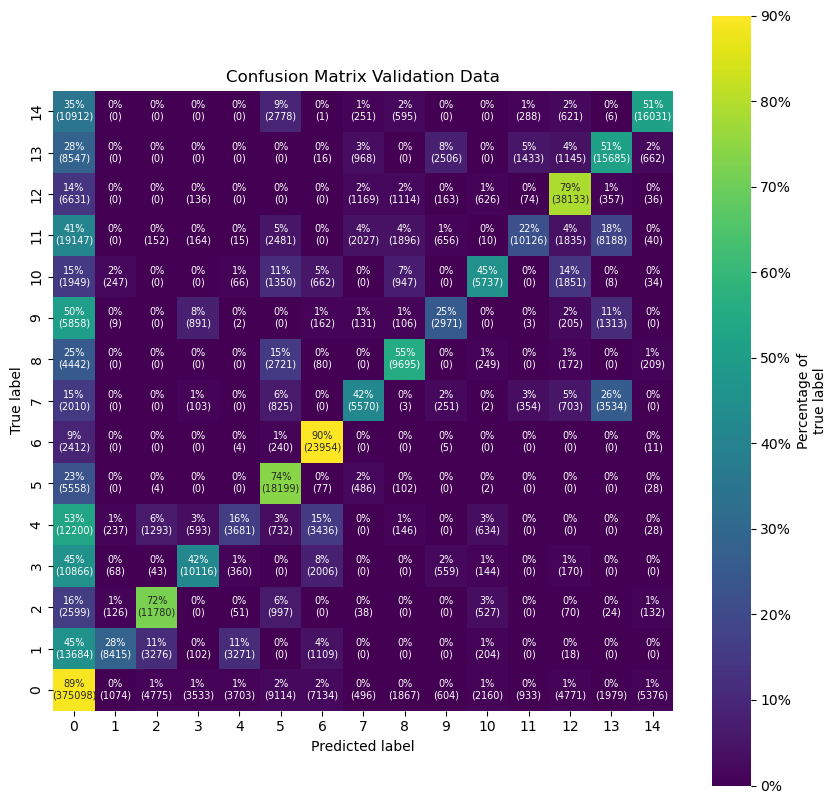

In [22]:
fig = plot_CM_mplt(Y.flatten(), Y_hat.flatten(), 'Confusion Matrix Validation Data', percentagereference='recall')

In [45]:
path = Path(r"C:\Users\Marc\OneDrive\Studium\Masterarbeit\Schreiben\Bilder\TikZtest")
tikzplotlib.save((path /"figure_mplt.tex").resolve(), figure=fig)

NameError: name 'tikzplotlib' is not defined

In [13]:

fig = plot_CM(Y.flatten(), Y_hat.flatten(), 'Confusion Matrix Validation Data', height=800, width = 800, percentagereference='recall')

In [67]:
import tikzplotly

path = Path(r"C:\Users\Marc\OneDrive\Studium\Masterarbeit\Schreiben\Bilder\TikZtest")
tikzplotly.save((path /"figure.tex").resolve(), fig)

d:\Programme\Anaconda3\envs\gestclass2\Lib\site-packages\tikzplotly\_heatmap.py:96: UserWarning:

Text template is not supported yet.

d:\Programme\Anaconda3\envs\gestclass2\Lib\site-packages\tikzplotly\_heatmap.py:53: UserWarning:

png image has not been reduced, see https://github.com/thomas-saigre/tikzplotly/issues/6#issuecomment-2106180586



In [ ]:
plot_CM(foldsprocessors[1].window_sets_processed['valid']['Y'], Y_hat_valid, 'Confusion Matrix Validation Data', percentagereference='recall')
plot_CM(foldsprocessors[1].window_sets_processed['valid']['Y'], Y_hat_valid, 'Confusion Matrix Validation Data', percentagereference='precision')

c:\Users\mado\Documents\gesture_class\Skripts\Plots.py:18: RuntimeWarning:

invalid value encountered in divide



In [ ]:
px.histogram(T_valid.loc[(T_valid['n_gesture']==7) & (T_valid['Y']==0), 'Y_hat'], nbins = 15)


|# |	Name of the gesture |	Type of the gesture|
| --- | --- | --- |
|1 	|Grab 	        |Fine|
|2 	|Tap 	        |Coarse|
|3 	|Expand 	    |Fine|
|4 	|Pinch 	        |Fine|
|5 	|Rotation CW 	|Fine|
|6 	|Rotation CCW 	|Fine|
|7 	|Swipe Right 	|Coarse|
|8 	|Swipe Left 	|Coarse|
|9 	|Swipe Up 	    |Coarse|
|10 |	Swipe Down 	|Coarse|
|11 |	Swipe X 	|Coarse|
|12 |	Swipe + 	|Coarse|
|13 |	Swipe V 	|Coarse|
|14 |	Shake 	    |Coarse|

In [10]:
%version_information tensorflow, numpy, matplotlib, plotly, pandas, keras, seaborn

Software,Version
Python,3.12.2 64bit [MSC v.1916 64 bit (AMD64)]
IPython,8.25.0
OS,Windows 10 10.0.19045 SP0
tensorflow,2.16.1
numpy,1.26.4
matplotlib,3.8.0
plotly,5.9.0
pandas,2.2.1
keras,3.1.1
seaborn,0.13.2
